In [1]:
import os
import random
import pickle
from matplotlib import pyplot as plt
import skimage
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision

%run ../metric_dissimilarity.py

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Load classes
classes = {}
with open("data/variants.txt", "r") as f:
  for cls_id, line in enumerate(f):
    cls = line.strip()
    classes[cls] = cls_id

# Load images
X_train = []
Y_train = []

X_test = []
Y_test = []

with open("data/images_variant_trainval.txt", "r") as f:
  for line in f:
    img_id, cls = line.strip().split(" ", 1)
    img = skimage.io.imread(f"data/processed/{img_id}.jpg")
    cls_id = classes[cls]
    X_train.append(img)
    Y_train.append(cls_id)

with open("data/images_variant_test.txt", "r") as f:
  for line in f:
    img_id, cls = line.strip().split(" ", 1)
    img = skimage.io.imread(f"data/processed/{img_id}.jpg")
    cls_id = classes[cls]
    X_test.append(img)
    Y_test.append(cls_id)

# Convert to numpy
X_train = np.array(X_train, dtype = np.uint8)
Y_train = np.array(Y_train, dtype = np.int64)

X_test = np.array(X_test, dtype = np.uint8)
Y_test = np.array(Y_test, dtype = np.int64)

In [3]:
with open("data/aircraft_osr_splits.pkl", "rb") as f:
  open_set = pickle.load(f)

# Create the open set train set
train_known_indices = np.isin(Y_train, open_set["known_classes"])
X_train_known = X_train[train_known_indices]
Y_train_known = Y_train[train_known_indices]

test_known_indices = np.isin(Y_test, open_set["known_classes"])
test_unknown_indices = ~test_known_indices

test_easy_indices = np.isin(Y_test, open_set["unknown_classes"]["Easy"])
test_hard_indices = np.isin(Y_test, open_set["unknown_classes"]["Hard"] + open_set["unknown_classes"]["Medium"])

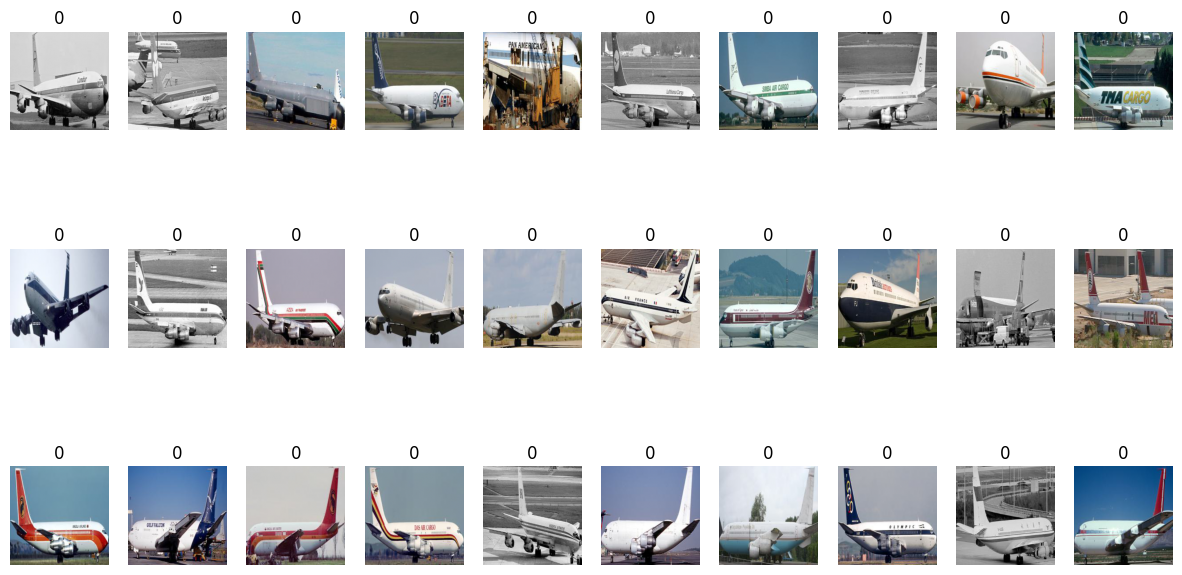

In [4]:
# Visualize some images and their corresponding labels.
plt.figure(figsize=(15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X_train[i] / 255.)
  plt.title(Y_train[i])
  plt.axis("off")

In [5]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels, augment=True):
    self.images = images
    self.labels = labels
    self.augment = augment

    self.transform = A.Compose([
      A.RandomCrop(200, 200),
      A.VerticalFlip(),
      A.HorizontalFlip(),
      A.Rotate(),
      A.GaussianBlur(),
      A.RandomBrightnessContrast(),
      ToTensorV2()
    ])

  def __len__(self):
     return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    if self.augment:
      image = self.transform(image=image)["image"]
    else:
      image = ToTensorV2()(image=image)["image"]

    image = image / 255.

    return image, label

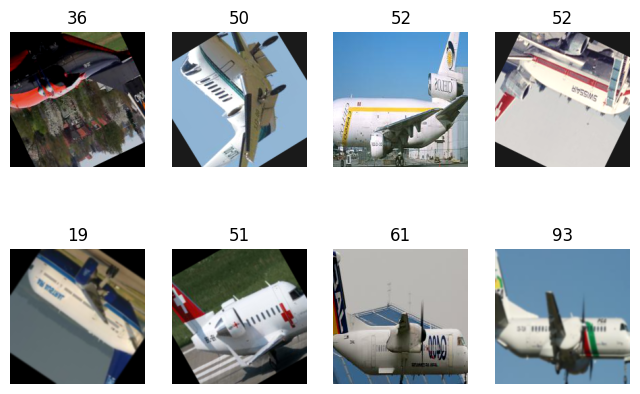

In [6]:
dataset = ImageDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(8):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
  plt.title(labels[i].numpy())
  plt.axis("off")

In [7]:
class Model(torch.nn.Module):
  def __init__(self, n_classes):
    super(Model, self).__init__()

    # Load EfficientNetV2-S as the shared network
    self.network = torchvision.models.get_model("efficientnet_v2_s", weights="DEFAULT")

    # Freeze the base network
    for param in self.network.parameters():
      param.requires_grad = False

    # Replace the last classification layer with a set of custom layers
    self.network.classifier = torch.nn.Sequential(
      torch.nn.Linear(self.network.classifier[1].in_features, 512),
      torch.nn.ReLU(),
      torch.nn.Dropout(p=0.2),
      torch.nn.Linear(512, 256),
      torch.nn.ReLU(),
      torch.nn.Dropout(p=0.2),
      torch.nn.Linear(256, n_classes)
    )

  def forward(self, x):
    # Pass the input through the shared network
    x = self.network(x)
    return x

  def freeze_network(self):
    for param in self.network.parameters():
      param.requires_grad = False

  def unfreeze_network(self):
    for param in self.network.parameters():
      param.requires_grad = True

In [8]:
def train_model(X, Y, model_id, batch_size=32, epochs=600):

  # Define the model filename based on model_id
  model_filename = f"models/baseline-{model_id}.pth"
  print(model_filename)

  # Define computation device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Recode the output since some classes might have been removed
  Y = sklearn.preprocessing.LabelEncoder().fit_transform(Y)

  # Initialize model and optimizer
  n_classes = len(np.unique(Y))
  model = None

  # Load pre-trained model if exists
  if os.path.isfile(model_filename):
    model = Model(n_classes)
    model.load_state_dict(torch.load(model_filename, weights_only=True))
    model.to(device)

  # Train a new model if not loaded
  if model is None:

    dataset = ImageDataset(X, Y)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = Model(n_classes)
    model.to(device)

    # Initialize loss, optimizer, and training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()

    # Warmup top layers
    epoch_loss = 0
    for epoch in range(20):
      for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Compute average epoch loss
      print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")
      epoch_loss = 0

    # Unfreeze the network
    model.unfreeze_network()

    # Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Add a learning rate scheduler with linear warmup
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.0001, total_iters=20)
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=(epochs // 3))
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[lr_scheduler, cosine_scheduler], milestones=[20])

    # Train
    epoch_loss = 0
    for epoch in range(epochs):
      for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Step scheduler
      scheduler.step()

      # Compute average epoch loss
      print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")
      epoch_loss = 0

    # Save the trained model
    torch.save(model.state_dict(), model_filename)

  # Freeze the model parameters
  for param in model.parameters():
    param.requires_grad = False

  # Set to evaluation mode
  model.eval()

  return model

In [9]:
# Model training
sizes = [5, 10, 20, 50]
subset_data = {}

n_classes = len(np.unique(Y_train_known))

models = {}
for size in sizes:
  # Create a subset of the training data
  str_split = StratifiedShuffleSplit(n_splits=1, train_size=size / 100.0, random_state=42)
  train_idx, _ = next(str_split.split(X_train_known, Y_train_known))

  subset_data[size] = {
    "X_train": X_train_known[train_idx],
    "Y_train": Y_train_known[train_idx],
  }

  # Make sure that all classes are represented in the subset
  if len(np.unique(subset_data[size]["Y_train"])) < n_classes:
    raise ValueError(f"Subset of size {size} does not contain all classes from the known set.")
  
  models[size] = train_model(subset_data[size]["X_train"], subset_data[size]["Y_train"], f"effnet-s{size}")

models/baseline-effnet-s5.pth
Epoch 1, Loss: 3.9120
Epoch 2, Loss: 3.9065
Epoch 3, Loss: 3.9069
Epoch 4, Loss: 3.9141
Epoch 5, Loss: 3.9023
Epoch 6, Loss: 3.9015
Epoch 7, Loss: 3.9117
Epoch 8, Loss: 3.8987
Epoch 9, Loss: 3.8960
Epoch 10, Loss: 3.8922
Epoch 11, Loss: 3.8883
Epoch 12, Loss: 3.8782
Epoch 13, Loss: 3.8860
Epoch 14, Loss: 3.8806
Epoch 15, Loss: 3.8739
Epoch 16, Loss: 3.8683
Epoch 17, Loss: 3.8592
Epoch 18, Loss: 3.8607
Epoch 19, Loss: 3.8433
Epoch 20, Loss: 3.8538
Epoch 1, Loss: 3.8686
Epoch 2, Loss: 3.8559
Epoch 3, Loss: 3.8485
Epoch 4, Loss: 3.8379
Epoch 5, Loss: 3.8664
Epoch 6, Loss: 3.8429
Epoch 7, Loss: 3.8498
Epoch 8, Loss: 3.8294
Epoch 9, Loss: 3.8398
Epoch 10, Loss: 3.8435
Epoch 11, Loss: 3.8360
Epoch 12, Loss: 3.8419
Epoch 13, Loss: 3.8348
Epoch 14, Loss: 3.8507
Epoch 15, Loss: 3.8449
Epoch 16, Loss: 3.8340
Epoch 17, Loss: 3.8438
Epoch 18, Loss: 3.8360
Epoch 19, Loss: 3.8348
Epoch 20, Loss: 3.8411
Epoch 21, Loss: 3.8338
Epoch 22, Loss: 3.8043
Epoch 23, Loss: 3.8371

In [10]:
for size in sizes:
  # Prediction
  np.random.seed(42)

  # Make predictions
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  dataset = ImageDataset(X_test, Y_test, augment = False)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

  logits = []
  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      logits.append(models[size](images).cpu())

  # Concatenate logits
  logits = torch.cat(logits, dim=0)
  probs = torch.nn.functional.softmax(logits, dim=1)
  preds = torch.argmax(probs, dim=1)

  # Convert back to numpy
  logits = logits.numpy()
  probs = probs.numpy()
  preds = preds.numpy()

  # Map the predictions to the known classes
  known_classes = np.unique(Y_train_known)
  preds = known_classes[preds]

  # Closed-set accuracy
  closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

  # Open-set scores
  msp = compute_msp(probs)
  mls = compute_mls(logits)

  # AUROC
  msp_easy_auroc = open_auroc(-msp, test_known_indices, test_easy_indices)
  mls_easy_auroc = open_auroc(-mls, test_known_indices, test_easy_indices)
  msp_hard_auroc = open_auroc(-msp, test_known_indices, test_hard_indices)
  mls_hard_auroc = open_auroc(-mls, test_known_indices, test_hard_indices)

  msp_easy_openauc = openauc(-msp, preds, Y_test, test_known_indices, test_easy_indices)
  mls_easy_openauc = openauc(-mls, preds, Y_test, test_known_indices, test_easy_indices)
  msp_hard_openauc = openauc(-msp, preds, Y_test, test_known_indices, test_hard_indices)
  mls_hard_openauc = openauc(-mls, preds, Y_test, test_known_indices, test_hard_indices)

  # Print results
  pct  = lambda x: f"{x*100:.1f}%"
  fmt  = lambda x: f"{x*100:.1f}"
  pair = lambda a, b: f"{fmt(a)}/{fmt(b)}"

  closed = pct(closed_acc)

  rows = [
    ("MSP", closed, pair(msp_easy_auroc, msp_hard_auroc), pair(msp_easy_openauc, msp_hard_openauc)),
    ("MLS", closed, pair(mls_easy_auroc, mls_hard_auroc), pair(mls_easy_openauc, mls_hard_openauc)),
  ]

  print(f"{'':<8}{'Closed':>10}{'AUROC E/H':>12}{'OpAUC E/H':>12}")
  print("-"*46)
  for method, cl, au, op in rows:
    print(f"{method:<8}{cl:>10}{au:>12}{op:>12}")

  # CSV
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,,Acck,,{closed_acc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MSP,AUROC,Easy,{msp_easy_auroc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MSP,AUROC,Hard,{msp_hard_auroc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MLS,AUROC,Easy,{mls_easy_auroc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MLS,AUROC,Hard,{mls_hard_auroc}") 
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MSP,OpAUC,Easy,{msp_easy_openauc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MSP,OpAUC,Hard,{msp_hard_openauc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MLS,OpAUC,Easy,{mls_easy_openauc}")
  print(f"Aircraft,All,Holdout,EfficientNetV2,{size},Baseline,MLS,OpAUC,Hard,{mls_hard_openauc}")

            Closed   AUROC E/H   OpAUC E/H
----------------------------------------------
MSP          27.1%   56.2/56.9   20.2/20.5
MLS          27.1%   58.2/58.2   20.1/20.1
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,,Acck,,0.2709832134292566
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MSP,AUROC,Easy,0.5620364278292508
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MSP,AUROC,Hard,0.569281248348015
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MLS,AUROC,Easy,0.5816552155576887
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MLS,AUROC,Hard,0.5821883575304085
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MSP,OpAUC,Easy,0.20201589852555735
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MSP,OpAUC,Hard,0.20501915101185583
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MLS,OpAUC,Easy,0.20132919151934825
Aircraft,All,Holdout,EfficientNetV2,5,Baseline,MLS,OpAUC,Hard,0.2007402094356579
            Closed   AUROC E/H   OpAUC E/H
----------------------------------------------
MSP        